In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.mixture import GaussianMixture 
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
import itertools
from tqdm import tqdm


## Clustering of Merchants
### **Objective**: Perform a hard clustering on the merchants to obtain 3 to 5 clusters, which can be used for market segmentation
### **Clustering pipeline**:
 0. Preliminary Data Analysis
 1. Data Clustering
    1. K-means
    2. MeanShift
    3. DBSCAN
    4. Gaussian Mixture Model
 2. Clustering Evaluation
    1. Silhouette Coefficient
    2. Calinski-Harabasz Index
    3. Davies-Bouldin Index
 3. Clustering Model Deployment


In [81]:
merchant_df = pd.read_csv("agg_transaction_train.csv")
merchant_df = merchant_df[["merchant_abn",
                           "total_number_of_distinct_customers",
                           "monthly_average_number_of_orders",
                           "monthly_average_bnpl_revenue",
                           "take_rate"
                           ]]
merchant_df.head(5)

,merchant_abn,total_number_of_distinct_customers,monthly_average_number_of_orders,monthly_average_bnpl_revenue,take_rate
0,10023283211,2619,154.333333,33301.586223,0.1
1,10342410215,729,40.888889,15624.420327,6.3
2,10346855916,7,1.400000,2186.800497,3.5
3,10385163239,57,3.352941,1162.535621,6.6
4,10648956813,13062,1049.722222,67759.983409,6.6


### **PDA**

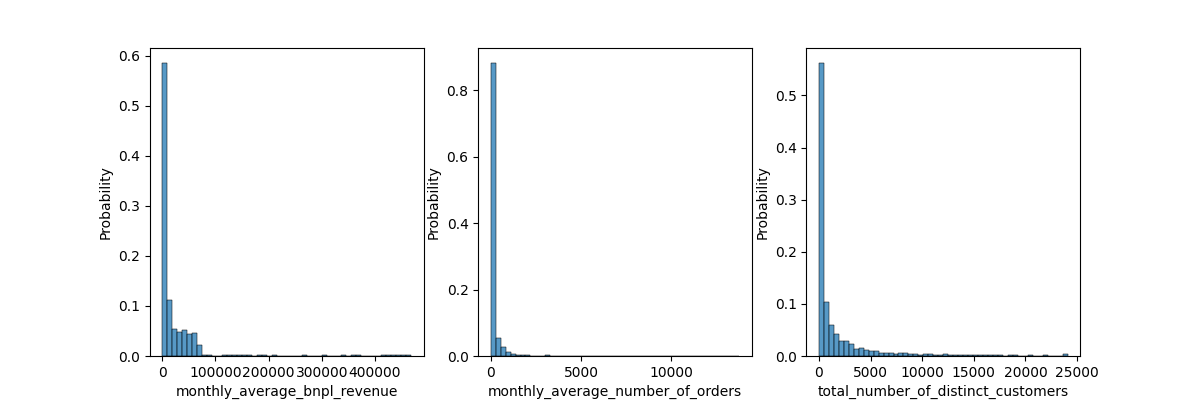

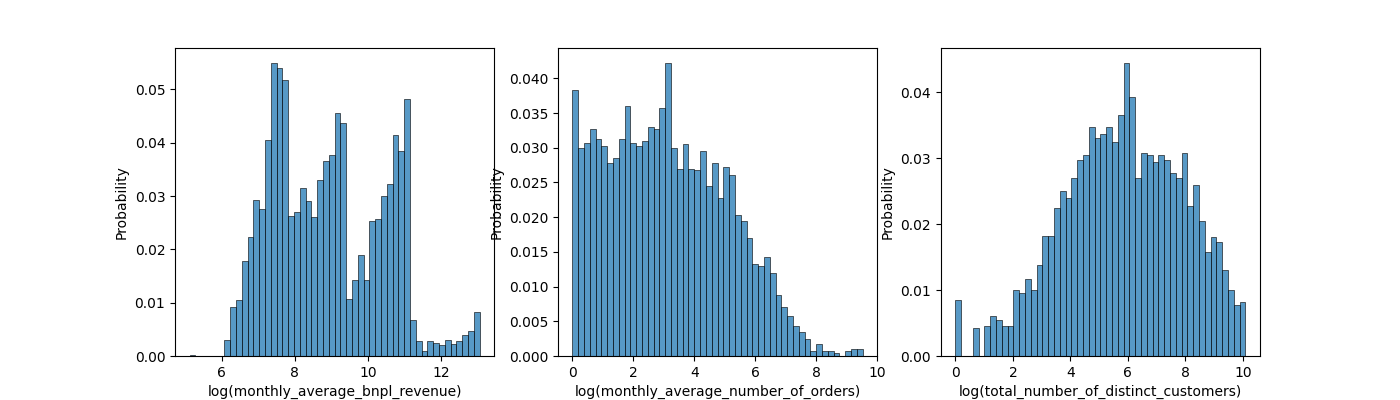

In [52]:
features = [
            "monthly_average_bnpl_revenue",
            "monthly_average_number_of_orders",
            "total_number_of_distinct_customers"
            ]

fig, ax = plt.subplots(1, 3, figsize = (12, 4), dpi = 100)
for i in range(len(features)):
    sns.histplot(merchant_df[features[i]], 
                stat = 'probability', 
                bins=50,
                ax = ax[i])


# It seems that we can perform GMM on log(features)
fig, ax = plt.subplots(1, 3, figsize = (14, 4), dpi = 100)
for i in range(len(features)):
    sns.histplot(merchant_df[features[i]].apply(np.log), 
                stat = 'probability', 
                bins=50,
                ax = ax[i])
    ax[i].set_xlabel(f'log({ax[i].get_xlabel()})')

### **Clustering**

In [5]:
X = merchant_df[features]
log_X = X.apply(np.log)

def homemade_GridSearch(model, parameters, data, eval_metrics=[silhouette_score, davies_bouldin_score]):
    """
    return a dataframe showing the gridsearch result
    """
    # Name of the parameters
    parameter_names = list(parameters.keys())
    # Name of the evaluation metrics
    eval_metric_names = ['silhouette_score', 'davies_bouldin_score']

    # Store the performance in a dict
    performance_dict = {parameter: [] for parameter in parameter_names + eval_metric_names + ["num_clusters"]}

    for parameter_value in tqdm(itertools.product(*map(parameters.get, list(parameter_names)))):
        # Store the combination of parameters in a dict
        parameter_set = dict(zip(parameter_names, parameter_value))
        labels = model.set_params(**parameter_set).fit_predict(data)
        # Store the parameters and corresponding score
        for parameter_name in parameter_names:
            performance_dict[parameter_name].append(parameter_set[parameter_name])
        for eval_metric_name, eval_metric in zip(eval_metric_names, eval_metrics):
            try:
                score = eval_metric(data, labels)
            except:
                # If score cannot be calculated, return NaN
                score = np.nan
            performance_dict[eval_metric_name].append(score)
       
        # Add an additional column indicating the number of clusters
        performance_dict["num_clusters"].append(len(np.unique(labels)))

    return pd.DataFrame(performance_dict)
       


### K-Means

In [71]:
k_mean_params = {
    'n_clusters': [3, 4, 5],
    'random_state': [2022, ]
}

homemade_GridSearch(KMeans(), k_mean_params, X)

3it [00:01,  3.00it/s]


,n_clusters,random_state,silhouette_score,davies_bouldin_score,num_clusters
0,3,2022,0.761312,0.385205,3
1,4,2022,0.765534,0.443601,4
2,5,2022,0.766876,0.441407,5


### MeanShift

In [13]:
mean_shift_params = {
     'bandwidth': [estimate_bandwidth(X, quantile=q) for q in np.linspace(0.1, 0.9, num=5)]
     }

homemade_GridSearch(MeanShift(), mean_shift_params, X)

5it [01:06, 13.27s/it]


,bandwidth,silhouette_score,davies_bouldin_score,num_clusters
0,12051.688326,0.638490,0.698235,24
1,20213.934983,0.644909,0.664463,10
2,24304.822285,0.665322,0.566736,8
3,32052.351999,0.651295,0.457699,6
4,59031.452160,0.802792,0.509808,5


### DBSCAN

In [53]:
from scipy.spatial import distance
pairwise_distance = (distance.cdist(X, X, metric='euclidean')).ravel()

dbscan_params = {
    'eps': [10, 100, 1000, 10000],
    'min_samples': [1, 5, 10, 20, 50, 100, 500, 1000]
}

homemade_GridSearch(DBSCAN(), dbscan_params, X)

32it [00:08,  3.78it/s]


,eps,min_samples,silhouette_score,davies_bouldin_score,num_clusters
0,10,1,0.099148,0.063485,3530
1,10,5,-0.606872,1.214088,11
2,10,10,NaN,NaN,1
3,10,20,NaN,NaN,1
4,10,50,NaN,NaN,1
5,10,100,NaN,NaN,1
6,10,500,NaN,NaN,1
7,10,1000,NaN,NaN,1
8,100,1,-0.192447,0.134386,1682
9,100,5,-0.302182,1.222633,26


### Gaussian Mixture Model

In [65]:
gmm_params = {
    'n_components': np.arange(1, 20),
    'init_params': ['kmeans', 'random'],
    'random_state': [2022, ]
}

display(homemade_GridSearch(GaussianMixture(), gmm_params, X))
homemade_GridSearch(GaussianMixture(), gmm_params, log_X)

38it [00:22,  1.72it/s]


,n_components,init_params,random_state,silhouette_score,davies_bouldin_score,num_clusters
2,2,kmeans,2022,0.339673,0.693710,2
4,3,kmeans,2022,0.353276,0.751545,3
6,4,kmeans,2022,0.322762,0.849071,4
8,5,kmeans,2022,0.246093,0.896902,5
10,6,kmeans,2022,0.278105,0.929213,6


### Cluster Visualization

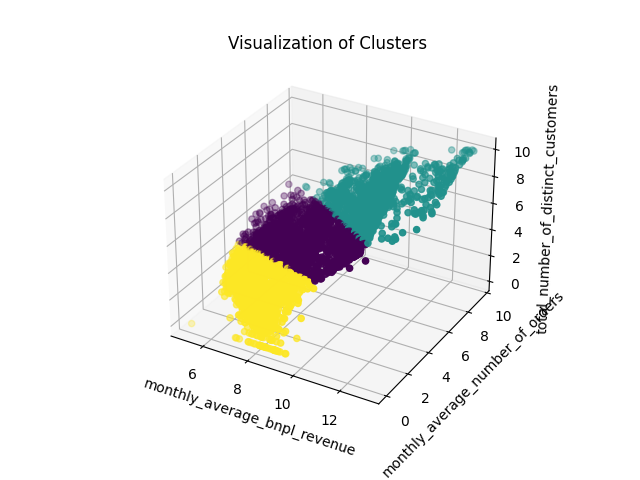

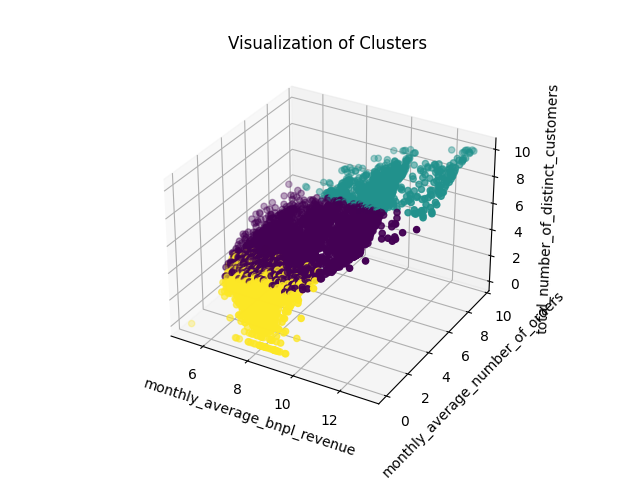

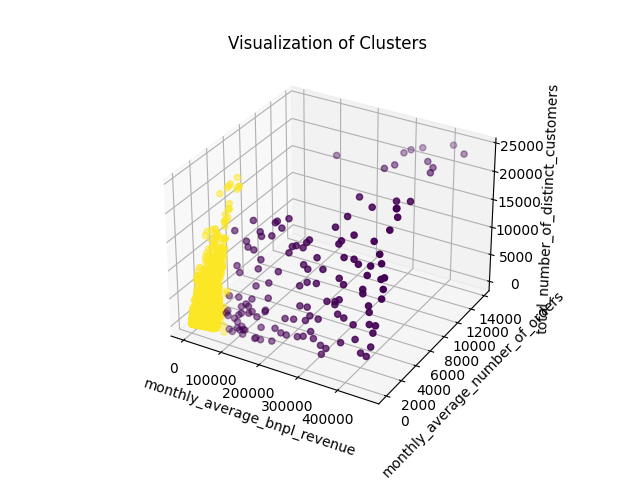

In [47]:
# 需要改的地方
%matplotlib ipympl

def visualize_cluster(model, data):
    """
    return a figure of clusters
    """
    data_copy = data.copy()

    # Define X, Y and Z axes
    xs = data_copy[features[0]]
    ys = data_copy[features[1]]
    zs = data_copy[features[2]]
    
    # Clusters of the data
    data_copy["cluster"] = model.fit_predict(data_copy)

    # Create a figure
    figure = plt.figure(dpi = 100)
    ax = figure.add_subplot(projection='3d')
    ax.scatter(xs, ys, zs, c=data_copy["cluster"])

    ax.set_title("Visualization of Clusters")
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel(features[2])
    
    return figure

fg1 = visualize_cluster(KMeans(n_clusters=3), log_X)
fg2 = visualize_cluster(GaussianMixture(n_components=3, init_params='kmeans'), log_X)
fg3 = visualize_cluster(DBSCAN(eps=10000, min_samples=20), X)

In [105]:
# Final clustering model
gmm = GaussianMixture(n_components=3, init_params='kmeans').fit(X)
merchant_df["label"] = gmm.predict(X)

# Predict the cluster of the unknown merchants 
pred = pd.read_csv("agg_transaction_pred.csv")
pred["label"] = gmm.predict(pred[features].apply(np.log))
pd.concat([merchant_df[["merchant_abn", "label"]], pred[["merchant_abn", "label"]]]).to_csv("merchant_clusters.csv", index=False)


# Fill missing take rate with cluster mean
merchant_df.groupby("label", as_index=False)["take_rate"].mean().to_csv("take_rate.csv", index=False)